In [1]:
# from aemulusnu_massfunction.utils import *
# from aemulusnu_massfunction.massfunction import *

import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import os
import emcee
import sys
import numpy as np
import pickle

cosmos_f = open('../data/cosmo_params.pkl', 'rb')
cosmo_params = pickle.load(cosmos_f) #cosmo_params is a dict
cosmos_f.close()

X = []
Y = []
idx = {}
cidx = 0
weird_boxes = []
for box in cosmo_params:
    if(box in weird_boxes):
        continue
    X += [box]
    idx[box] = cidx
    cidx+=1
    Y += [[cosmo_params[box][key] for key in cosmo_params[box]]]
    
X = np.array(X)
Y = np.array(Y)

from aemulusnu_hmf.utils import Normalizer

# Assuming Y is your input matrix with shape (n_samples, n_features)
# Create an instance of StandardScaler
scaler = Normalizer()

# Fit the scaler to the data
scaler.fit(Y)

# Standardize the data
Y = scaler.transform(Y)

print(len(X))

def find_most_central_datapoint_index(Y):
    centroid = np.mean(Y, axis=0)
    distances = np.linalg.norm(Y - centroid, axis=1)
    most_central_index = np.argmin(distances)
    return most_central_index
print('most central: ', X[find_most_central_datapoint_index(Y)])

def dist(a,b):
    return np.sqrt(np.sum(np.square(np.array(Y[b])-np.array(Y[a]))))

edges = [[dist(i,j) for i in range(len(X))] for j in range(len(X))]


import sys

def find_min_key(key, mst_set, n):
    min_key = sys.maxsize
    min_index = -1
    for i in range(n):
        if key[i] < min_key and not mst_set[i]:
            min_key = key[i]
            min_index = i
    return min_index

def prim_mst(edges, n):
    parent = [None] * n
    key = [sys.maxsize] * n
    mst_set = [False] * n

    key[0] = 0  # Start with the first node as the root
    parent[0] = -1  # Root has no parent

    for _ in range(n - 1):
        u = find_min_key(key, mst_set, n)
        mst_set[u] = True

        for v in range(n):
            if edges[u][v] > 0 and not mst_set[v] and edges[u][v] < key[v]:
                key[v] = edges[u][v]
                parent[v] = u

    mst = [[0] * n for _ in range(n)]
    for i in range(1, n):
        mst[i][parent[i]] = edges[i][parent[i]]
        mst[parent[i]][i] = edges[parent[i]][i]

    return mst

n = len(edges)

mst = prim_mst(edges, n)

from collections import deque

def bfs_traversal(mst, start):
    tot = 0
    n = len(mst)
    visited = [False] * n
    parent = [None] * n

    queue = deque()
    queue.append(start)
    visited[start] = True

    while queue:
        node = queue.popleft()
        print("%-10s"%(X[node]), end='\t ')
        if parent[node] is not None:
            prev = parent[node]
            dist = np.sqrt(np.sum(np.square(np.array(Y[idx[X[node]]])- np.array(Y[idx[X[prev]]]))))
            tot += dist
            curr_params_fname = "/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_params.pkl"%(X[node]) 
            curr_params = None
            with open(curr_params_fname, "rb") as f:
                curr_params = pickle.load(f)
            prev_params_fname = "/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_params.pkl"%(X[parent[node]]) 
            prev_params = None
            with open(prev_params_fname, "rb") as f:
                prev_params = pickle.load(f)
            print("Prev: %-10s\t distance:%.2f"%(X[parent[node]], dist))
            for key in prev_params:
                if(np.abs(prev_params[key]-curr_params[key])/curr_params[key] > .1):
                    print('\t%s\n\t\tPrev:%.2f\n\t\tCurr:%.2f'%(key,prev_params[key], curr_params[key]))
        print()

        for neighbor in range(n):
            if mst[node][neighbor] > 0 and not visited[neighbor]:
                queue.append(neighbor)
                visited[neighbor] = True
                parent[neighbor] = node
    assert(all(visited))
    print(tot)

start_node = idx['Box_n50_0_1400'] # Starting node for traversal

bfs_traversal(mst, start_node)


150
most central:  Box_n50_0_1400
Box_n50_0_1400	 
Box_n50_14_1400	 Prev: Box_n50_0_1400	 distance:0.26

Box_n50_21_1400	 Prev: Box_n50_0_1400	 distance:0.29
	d1
		Prev:0.01
		Curr:0.01
	g1
		Prev:0.04
		Curr:0.07

Box_n50_33_1400	 Prev: Box_n50_0_1400	 distance:0.29
	d1
		Prev:0.01
		Curr:0.01
	g1
		Prev:0.04
		Curr:0.04

Box_n50_35_1400	 Prev: Box_n50_0_1400	 distance:0.25
	d1
		Prev:0.01
		Curr:0.01

Box_n50_44_1400	 Prev: Box_n50_0_1400	 distance:0.30
	d1
		Prev:0.01
		Curr:0.04
	g1
		Prev:0.04
		Curr:0.03

Box3_1400 	 Prev: Box_n50_14_1400	 distance:0.39
	d1
		Prev:0.01
		Curr:0.02
	f1
		Prev:0.23
		Curr:0.20
	g1
		Prev:0.04
		Curr:0.04

Box_n50_36_1400	 Prev: Box_n50_21_1400	 distance:0.21

Box_n50_19_1400	 Prev: Box_n50_33_1400	 distance:0.26
	d1
		Prev:0.01
		Curr:0.01
	g1
		Prev:0.04
		Curr:0.02

Box_n50_37_1400	 Prev: Box_n50_33_1400	 distance:0.19
	d1
		Prev:0.01
		Curr:0.01
	f1
		Prev:0.20
		Curr:0.23
	g1
		Prev:0.04
		Curr:0.05

Box_n50_42_1400	 Prev: Box_n50_33_1400	 dist

Box45_1400	 Prev: Box27_1400	 distance:0.53
	d1
		Prev:0.02
		Curr:0.03
	g1
		Prev:0.03
		Curr:0.01

Box89_1400	 Prev: Box98_1400	 distance:0.44
	g1
		Prev:0.05
		Curr:0.04

Box34_1400	 Prev: Box_n50_27_1400	 distance:0.35

Box_n50_40_1400	 Prev: Box_n50_27_1400	 distance:0.38

Box74_1400	 Prev: Box35_1400	 distance:0.52
	d1
		Prev:0.12
		Curr:0.08
	g1
		Prev:0.01
		Curr:0.01

Box79_1400	 Prev: Box35_1400	 distance:0.39
	d1
		Prev:0.12
		Curr:0.14
	g1
		Prev:0.01
		Curr:0.03

Box18_1400	 Prev: Box16_1400	 distance:0.33
	d1
		Prev:0.00
		Curr:0.00
	g1
		Prev:0.01
		Curr:0.01

Box28_1400	 Prev: Box16_1400	 distance:0.43
	d1
		Prev:0.00
		Curr:0.00
	e0
		Prev:1.10
		Curr:1.00

Box19_1400	 Prev: Box25_1400	 distance:0.38
	d1
		Prev:0.01
		Curr:0.02
	g1
		Prev:0.04
		Curr:0.03

Box41_1400	 Prev: Box25_1400	 distance:0.48
	d1
		Prev:0.01
		Curr:0.01
	f1
		Prev:0.19
		Curr:0.17

Box53_1400	 Prev: Box25_1400	 distance:0.44
	g1
		Prev:0.04
		Curr:0.06

Box76_1400	 Prev: Box25_1400	 distance:0.5

In [2]:
# Box_n50_19_1400	 Prev: Box_n50_33_1400	 distance:1.06
# Box_n50_16_1400	 Prev: Box_n50_19_1400	 distance:1.15
# Box_n50_24_1400	 Prev: Box_n50_19_1400	 distance:0.95
# Box66_1400	 Prev: Box_n50_26_1400	 distance:1.52
# Box38_1400	 Prev: Box53_1400	 distance:1.47

In [3]:
a_list_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/alist.pkl'
a_list_f = open(a_list_fname, 'rb')
a_list = pickle.load(a_list_f) 
a_list_f.close()

###TEMP
# a_list = [a_list[0], a_list[1]]
#######
print('alist', a_list)

alist [1.0, 0.953321, 0.866399, 0.787402, 0.715608, 0.65036, 0.620002, 0.591061, 0.563471, 0.537169, 0.512095, 0.488191, 0.403224, 0.366459, 0.302679]


In [4]:
from aemulusnu_hmf.massfunction import p

100%|██████████| 150/150 [00:00<00:00, 285.52it/s]


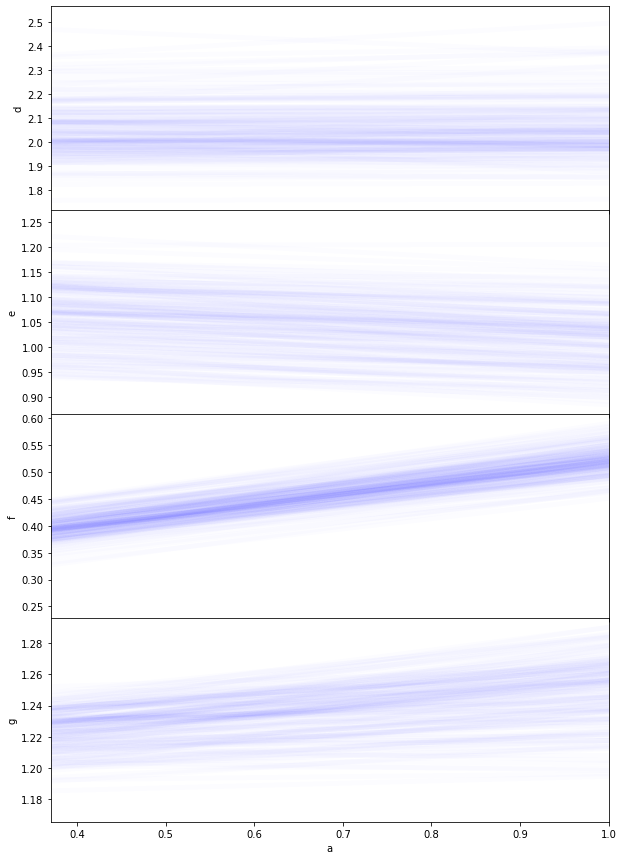

In [5]:
import matplotlib.pyplot as plt
box = 'Box50_1400'
box = 'Box0_1400'
# box = 'Box78_1400'
# box = 'Box_n50_13_1400'
# box = 'Box_n50_0_1400'
param_names = ['d','e','f','g']
ndim = len(param_names)
fig, axs = plt.subplots(ncols=1, nrows=4, figsize=(10,15), sharex=True)
plt.subplots_adjust(wspace=0, hspace=0)


meta_box = [[], [], [], []]
for box in tqdm(cosmo_params):
    TTTTT = False
    if(box in weird_boxes):
        continue
    MLE_params = []
    with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_params.pkl"%(box), "rb") as f:
        MLE_params = pickle.load(f)

    for i, param in enumerate(['d','e','f','g']):
        x0 = 0
        x1 = 1
        y0 = p(MLE_params[param+'0'], MLE_params[param+'1'], x0)
        y1 = p(MLE_params[param+'0'], MLE_params[param+'1'], x1)

        axs[i].plot([x0,x1], [y0,y1], alpha=0.01, lw=5, color='blue')

        axs[i].set_ylabel(param)
#         axs[i].set_ylim([0,2])
        axs[i].set_xlim([0.37, 1])

    axs[-1].set_xlabel('a')
# axs[0].set_ylim([2., 3.])
# axs[1].set_ylim([0.2, 1.2])
# axs[2].set_ylim([.3,.6])
# axs[3].set_ylim([1.2,1.3])


In [6]:
# meta_box = np.array(meta_box)
# print(meta_box.shape)

In [7]:
# import corner
# import numpy as np

# figure = corner.corner(meta_box.T,
#                       labels=param_names, 
#                        quantiles=[0.16, 0.5, 0.84],
#                        show_titles=True, return_kwargs={"axes": True})

In [8]:
# import matplotlib.pyplot as plt
# import numpy as np
# import pickle
# from sklearn.metrics import r2_score

# box = 'Box_n50_0_1400'
# # box = 'Box_n50_42_1400'
# # Function to fit a line and plot it
# def fit_and_plot_line(ax, x, y):
#     """
#     Fit a line to the data and plot it on the given axis
#     """
#     coefficients = np.polyfit((np.array(x)-0.5), y, 1)  # Fit a 1st degree polynomial (line)
#     m, b = coefficients  # slope and intercept

#     # Create a line using the fitted parameters
#     y_fit = m * (np.array(x)-0.5) + b

#     ax.plot(x, y_fit, color='red', linestyle='--')  # Plot the fitted line

#     r2 = r2_score(y, y_fit)
#     ax.text(0.1, 0.8, f'R^2={r2:.4f}', transform=ax.transAxes)

#     # Display the slope and intercept on the plot
#     ax.text(0.1, 0.9, f'm={m:.4f}, b={b:.4f}', transform=ax.transAxes)

# # Prepare the plot
# param_names = ['d', 'e', 'f', 'g']
# ndim = len(param_names)
# fig, axs = plt.subplots(ncols=1, nrows=4, figsize=(10, 15), sharex=True)
# plt.subplots_adjust(wspace=0, hspace=0)

# # Initialize dictionary to store parameters
# params = {'d':[], 'e':[], 'f':[], 'g':[]}
# for a in a_list:
#     with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_%.2f_params.pkl"%(box, a), "rb") as f:
#         MLE_params = pickle.load(f)
#     for key in MLE_params:
#         params[key] += [MLE_params[key]]

# # Plot the data and fit lines
# for i, param in enumerate(params):
#     axs[i].scatter(a_list, params[param], alpha=1, color='blue')

#     axs[i].plot(a_list, params[param], alpha=1, color='blue')
#     fit_and_plot_line(axs[i], a_list, params[param])  # Fit and plot the line

#     axs[i].set_ylabel(param)
# #     axs[i].set_ylim([0, 2])
#     axs[i].set_xlim([0.37, 1])

# # Set custom y-limits and x-labels
# axs[-1].set_xlabel('a')
# # axs[0].set_ylim([0, 0.75])
# # axs[1].set_ylim([0, 0.75])
# # axs[2].set_ylim([1.25, 2.25])
# # axs[3].set_ylim([1, 1.5])

In [9]:
# import matplotlib.pyplot as plt
# import numpy as np
# import pickle
# from sklearn.metrics import r2_score
# box = 'Box_n50_0_1400'
# # Function to fit a line and plot it
# def fit_and_plot_line(ax, x, y):
#     """
#     Fit a line to the data and plot it on the given axis
#     """
#     coefficients = np.polyfit(x, y, 1)  # Fit a 1st degree polynomial (line)
#     m, b = coefficients  # slope and intercept

#     # Create a line using the fitted parameters
#     y_fit = m * np.array(x) + b

#     ax.plot(x, y_fit, color='red', linestyle='--')  # Plot the fitted line
#     r2 = r2_score(y, y_fit)
#     ax.text(0.1, 0.8, f'R^2={r2:.4f}', transform=ax.transAxes)
#     # Display the slope and intercept on the plot
#     ax.text(0.1, 0.9, f'm={m:.4f}, b={b:.4f}', transform=ax.transAxes)

# # Prepare the plot
# param_names = ['d', 'e', 'f', 'g']
# ndim = len(param_names)
# fig, axs = plt.subplots(ncols=1, nrows=4, figsize=(10, 15), sharex=True)
# plt.subplots_adjust(wspace=0, hspace=0)

# # Pulled from log files
# params = {'d':[0.431,0.422,0.405,0.384,0.366,0.353,0.344,0.332,0.314,0.303,0.303,0.293,0.276,0.227], 
#           'e':[.3,   0.283,0.257,0.198,0.166,0.154,0.136,0.113,0.077,0.062,0.066,0.055,0.047,0.008], 
#           'f':[1.666,1.672,1.688,1.734,1.742,1.743,1.749,1.761,1.776,1.777,1.771,1.773,1.784,1.813], 
#           'g':[1.195,1.199,1.204,1.222,1.222,1.218,1.218,1.219,1.225,1.225,1.221,1.219,1.208,1.213]}

# # Plot the data and fit lines
# for i, param in enumerate(params):
#     axs[i].plot(a_list, params[param], alpha=1, color='blue')
#     fit_and_plot_line(axs[i], a_list, params[param])  # Fit and plot the line

#     axs[i].set_ylabel(param)
#     axs[i].set_ylim([0, 2])
#     axs[i].set_xlim([0.37, 1])

# # Set custom y-limits and x-labels
# axs[-1].set_xlabel('a')
# axs[0].set_ylim([0, 0.75])
# axs[1].set_ylim([0, 0.75])
# axs[2].set_ylim([1.25, 2.25])
# axs[3].set_ylim([1, 1.5])